# FDS Step by Step

## 1. Google Drive Mount and Module Import(Install)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 666 kB/s 
     |████████████████████████████████| 453 kB 59.0 MB/s 


In [ ]:
# 데이터 전처리
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook
import random
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from konlpy.tag import Okt

# lstm_model
import keras
from keras.layers import *
from keras import backend as K
from keras import optimizers
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Concatenate, BatchNormalization, Dropout
from keras.models import Sequential
from keras import Input, Model
import tensorflow as tf

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

# Word2Vec model
from gensim.models import Word2Vec, Phrases
from gensim.models import KeyedVectors

# 하이퍼 파라미터, CV(Cross Validation)
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score

from keras.callbacks import *
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

%matplotlib inline

In [ ]:
PROJECT_PATH = '/content/drive/MyDrive/Colab Notebooks'

## 2. Load Data

In [ ]:
dataset = pd.read_csv('{}/dataset.csv'.format(PROJECT_PATH),names=['text','fishing'])

In [ ]:
dataset['length'] = dataset['text'].apply(lambda x: len(x))
dataset = dataset.drop(dataset[dataset['length'] > 6000].index)

In [ ]:
dataset.head()

,text,fishing,length
0,"네, 지금 방송 중인 상품 사려고요.네, 무엇을 도와드릴까요?네 정보 확인 후 주문...",0,823
1,아 지금 방송하고 있는 거.예 아 그런데 제가 만약 생각 좀 해 보고 카드 결제로 ...,0,956
2,지금 방송하는 상품 주문되나요?제가 ㅇㅇ쇼핑에 등록되어 있지 않나요?휴대폰번호로 등...,0,1575
3,근무하시는 물어보세요 알아보니까 경룡 끝났는데 왜 저희는 그거를 다 소화를 할 수...,1,1903
4,네. 안녕하세요. 모바일로 주문하려고 해서 주문서를 쓰는데요.사만 팔천원으로 나오는...,0,1467


In [ ]:
fishing = len(dataset.loc[dataset['fishing']==0])
non_fishing = len(dataset.loc[dataset['fishing']==1])
num_data = len(dataset['fishing'])

print('정상 비율 {}% {}/{}'.format(round(non_fishing/num_data * 100,3),non_fishing,num_data))
print('보이스피싱 비율 {}% {}/{}'.format(round(fishing/num_data * 100,3),fishing,num_data))


정상 비율 7.543% 450/5966
보이스피싱 비율 92.457% 5516/5966


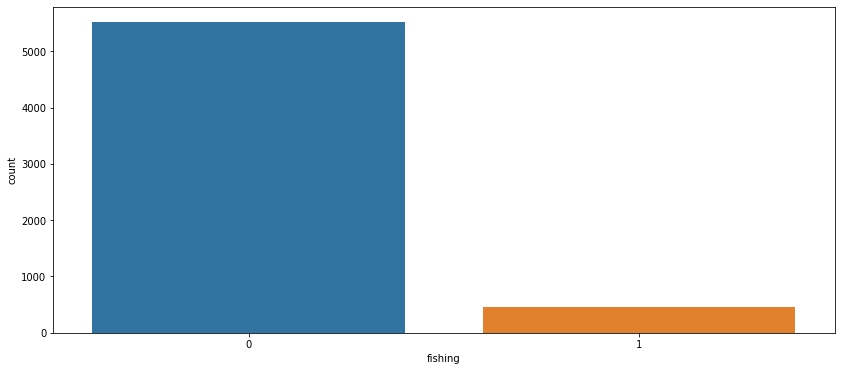

In [ ]:
plt.figure(figsize=(14,6))
sns.countplot(data=dataset,x='fishing')

In [ ]:
dataset['length'] = dataset['text'].apply(lambda x: len(x))
fishing = dataset.loc[dataset['fishing']==1]
non_fishing = dataset.loc[dataset['fishing']==0]

dataset.head()

,text,fishing,length
0,"네, 지금 방송 중인 상품 사려고요.네, 무엇을 도와드릴까요?네 정보 확인 후 주문...",0,823
1,아 지금 방송하고 있는 거.예 아 그런데 제가 만약 생각 좀 해 보고 카드 결제로 ...,0,956
2,지금 방송하는 상품 주문되나요?제가 ㅇㅇ쇼핑에 등록되어 있지 않나요?휴대폰번호로 등...,0,1575
3,근무하시는 물어보세요 알아보니까 경룡 끝났는데 왜 저희는 그거를 다 소화를 할 수...,1,1903
4,네. 안녕하세요. 모바일로 주문하려고 해서 주문서를 쓰는데요.사만 팔천원으로 나오는...,0,1467


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


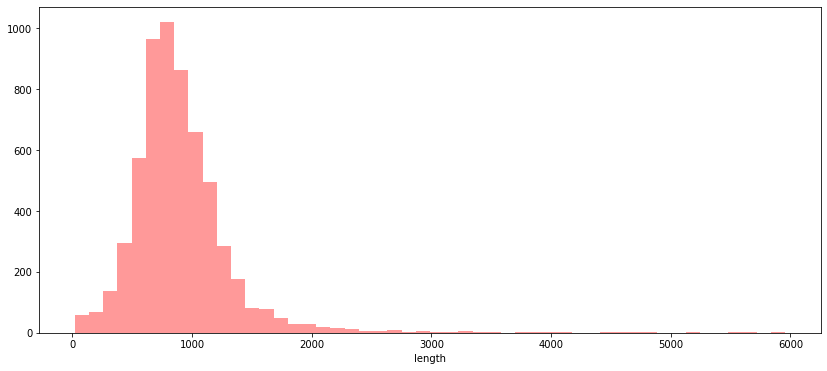

In [ ]:
plt.figure(figsize=(14,6))
sns.distplot(dataset['length'],kde=False, bins=50, color='r')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


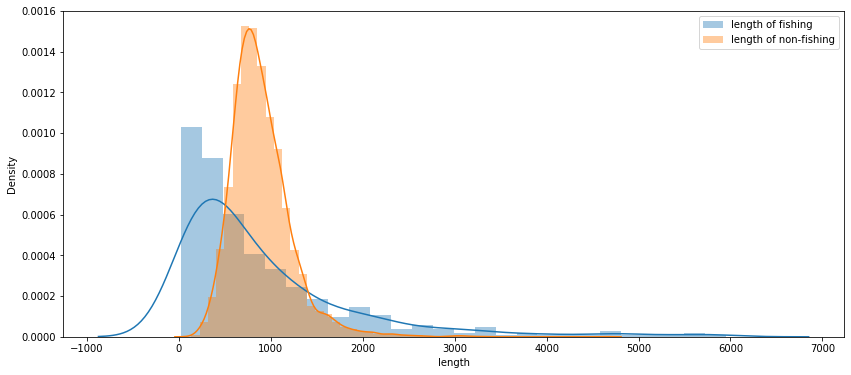

In [ ]:
plt.figure(figsize=(14,6))
sns.distplot(fishing['length'], label='length of fishing')
sns.distplot(non_fishing['length'], label='length of non-fishing')
plt.legend()

In [ ]:
dataset['length'].describe()

count    5966.000000
mean      895.357023
std       423.384594
min        20.000000
25%       661.000000
50%       831.000000
75%      1054.000000
max      5955.000000
Name: length, dtype: float64

In [ ]:
print(np.percentile(dataset['length'],80))
print('전체 평균 길이 : {}'.format(np.mean(dataset['length'])))
print('피싱 평균 길이 : {}'.format(np.mean(fishing['length'])))
print('정상 평균 길이 : {}'.format(np.mean(non_fishing['length'])))


1113.0
전체 평균 길이 : 895.3570231310761
피싱 평균 길이 : 918.5644444444445
정상 평균 길이 : 893.4637418419144


In [ ]:
iqr1 = dataset['length'].describe()['25%']
iqr3 = dataset['length'].describe()['75%']

ceil_outlier = iqr3 + 1.5 * (iqr3 - iqr1)
bot_outlier = iqr1 - 1.5 * (iqr3-iqr1)

outlier = (np.percentile(dataset['length'],5), np.percentile(dataset['length'],95))

(ceil_outlier, bot_outlier), outlier

((1643.5, 71.5), (394.25, 1555.25))

## 3. 데이터 전처리

### 3.1 불용어 제거 및 토크나이징

In [ ]:
okt = Okt()

In [ ]:
# 한글과 공백 문자를 제외한 문자 제거
dataset['text(clean)'] = dataset['text'].str.replace('[^가-힣\s]+', ' ')
dataset['text(clean)'] = dataset['text(clean)'].str.replace('  ', ' ')

# 문장에서 뜻이 될 만한 품사 태그
p = ['Noun','Verb','Adjective','Adverb']
# 불용어
stopwords = ['ㄱ','ㄴ,','ㄷ','ㄹ','ㅁ','ㅂ','ㅅ','ㅇ','ㅈ','ㅊ','ㅋ','ㅌ','ㅍ','ㅎ','ㅏ','ㅑ','ㅓ','ㅕ','ㅗ','ㅛ','ㅜ','ㅠ','ㅡ','ㅣ','가','나','다','라','마','바','사','아','자','차','카','타','파','하','가가','듀']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


### 3.2 문장 토큰화

In [ ]:
# 문장 토큰화
def tokenizer(data, pos=p, stopword=stopwords):
    tokened = okt.pos(data)

    return [word for word, tag in tokened if tag in pos and word not in stopword]

In [ ]:
dataset['tokenized'] = dataset['text(clean)'].apply(tokenizer)

In [ ]:
train = dataset[:4001]
test = dataset[4001:]

In [ ]:
train['tokenized'] = train['text(clean)'].apply(tokenizer)

print(train.shape)
train.head(2)

(4001, 5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,fishing,length,text(clean),tokenized
0,"네, 지금 방송 중인 상품 사려고요.네, 무엇을 도와드릴까요?네 정보 확인 후 주문...",0,823,네 지금 방송 중인 상품 사려고요 네 무엇을 도와드릴까요 네 정보 확인 후 주문...,"[네, 지금, 방송, 중인, 상품, 사려고요, 네, 무엇, 도, 드릴, 까요, 네,..."
1,아 지금 방송하고 있는 거.예 아 그런데 제가 만약 생각 좀 해 보고 카드 결제로 ...,0,956,아 지금 방송하고 있는 거 예 아 그런데 제가 만약 생각 좀 해 보고 카드 결제로 ...,"[지금, 방송, 있는, 거, 예, 제, 만약, 생각, 좀, 해, 보고, 카드, 결제..."


In [ ]:
test['tokenized'] = test['text(clean)'].apply(tokenizer)

print(test.shape)
test.head(2)

(1936, 5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,fishing,length,text(clean),tokenized
4031,네 제가 입력을 잘못해서 연결이 이쪽으로 됐네요.그게 신규 카드로 주문하려고 했는데...,0,728,네 제가 입력을 잘못해서 연결이 이쪽으로 됐네요 그게 신규 카드로 주문하려고 했는데...,"[네, 제, 입력, 잘못, 해서, 연결, 쪽, 됐네요, 그게, 신규, 카드, 주문,..."
4032,여기 방송 중인 상품 주문 하려는데요.구십 가능한가요?네 그럼 구십 사이즈로 해...,0,1059,여기 방송 중인 상품 주문 하려는데요 구십 가능한가요 네 그럼 구십 사이즈로 해...,"[여기, 방송, 중인, 상품, 주문, 하려는데요, 가능한가요, 네, 그럼, 사이즈,..."


### 3.3 데이터셋 분리(train, validation, test)

In [ ]:
fishings = dataset[dataset['fishing']==1]
normals = dataset[dataset['fishing']==0]

In [ ]:
len(fishings), len(normals)

(450, 5516)

In [ ]:
train_fishings = fishings[:252]
val_fishings = fishings[252:360]
test_fishings = fishings[360:]

In [ ]:
len(train_fishings), len(val_fishings), len(test_fishings)

(252, 108, 90)

In [ ]:
train_normals = normals[:3089]
val_normals = normals[3089:4413]
test_normals = normals[4413:]

In [ ]:
len(train_normals), len(val_normals), len(test_normals)

(3089, 1324, 1103)

In [ ]:
train = pd.concat([train_fishings,train_normals], ignore_index=True)
train = train.sample(frac=1).reset_index(drop=True)

In [ ]:
val = pd.concat([val_fishings,val_normals], ignore_index=True)
val = val.sample(frac=1).reset_index(drop=True)

In [ ]:
test = pd.concat([test_fishings,test_normals], ignore_index=True)
test = test.sample(frac=1).reset_index(drop=True)

## 4. 워드 임베딩(Word Embedding)

### 4.1 Word2Vec 모델 생성 및 학습

In [ ]:
bigrams = Phrases(sentences=dataset.tokenized)
trigrams = Phrases(sentences=bigrams[dataset.tokenized])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
N_SPLITS = 5
EMBEDDING_SIZE = 256

In [ ]:
tri_model = Word2Vec(sentences=trigrams[bigrams[dataset.tokenized]],size=EMBEDDING_SIZE,window=10,min_count=10,workers=4,sg=1)


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


### 4.2 Word2Vec 모델 저장 및 불러오기

In [ ]:
tri_model.wv.save_word2vec_format('{}/w2v_model'.format(PROJECT_PATH))

In [ ]:
tri_model = KeyedVectors.load_word2vec_format('{}/w2v_model'.format(PROJECT_PATH))

In [ ]:
max_word = len(tri_model.vocab)
print('vocabulary size : ',max_word)

vocabulary size :  6657


### 4.3 데이터 패딩 및 정수화

In [ ]:
def vectorize_data(data,vocab: dict) -> list:
    print('Vectorize sentences...',end='\r')
    keys=list(vocab.keys())
    filter_unknown = lambda word : vocab.get(word,None) is not None
    encode = lambda review : list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorie sentence.. (done)')
    return vectorized

In [ ]:
X_data = train.tokenized
input_length = max(list(map(len,X_data)))
X = pad_sequences(
    sequences = vectorize_data(X_data, vocab=tri_model.vocab),
    maxlen = input_length,
    padding = 'post'
)
y = train['fishing'].values

Vectorie sentence.. (done)


In [ ]:
X_test = pad_sequences(sequences=vectorize_data(test.tokenized, vocab=tri_model.vocab),
maxlen = input_length, padding = 'post')

Vectorie sentence.. (done)


In [ ]:
X_val = pad_sequences(sequences=vectorize_data(val.tokenized, vocab=tri_model.vocab),maxlen=input_length,padding='post')

y_val = val['fishing'].values

Vectorie sentence.. (done)


In [ ]:
X.shape, y.shape, X_val.shape, y_val.shape

((3341, 1582), (3341,), (1432, 1582), (1432,))

## 5. 어텐션(Attention)을 적용한 양방향 LSTM 모델

### 5.1 Attention Layer

In [ ]:
class Attention(Layer):
    def __init__(self, step_dim, W_regularizer=None, b_regularizer=None, W_constraint=None, b_constraint=None, bias=True, **kwargs):
        self.supports_masking = True
        self.init = keras.initializers.he_normal(seed=42)
        self.W_regularizer = keras.regularizers.get(W_regularizer)
        self.b_regularizer = keras.regularizers.get(b_regularizer)

        self.W_constraint = keras.constraints.get(W_constraint)
        self.b_constraint = keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],), initializer='zero', name='{}_b'.format(self.name), regularizer=self.b_regularizer, constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)
        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True)+K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'step_dim': self.step_dim,
            'W_regularizer': self.W_regularizer,
            'b_regularizer': self.b_regularizer,
            'W_constraint': self.W_constraint,
            'b_constraint': self.b_constraint,
            'bias': self.bias,
        })
        return config

### 5.2 NN LSTM Model

In [ ]:
def build_model(embedding_matrix: np.ndarray, input_length: int):
    model = keras.Sequential()

    model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], input_length=input_length, weights=[embedding_matrix], trainable=False))
    # 양방향 LSTM 층
    model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_activation='sigmoid', recurrent_dropout=0, return_sequences=True)))
    model.add(Attention(input_length))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(0.4))

    model.add(Dense(2, activation='Softmax'))
    adam = tf.optimizers.Adam(learning_rate=0.001, amsgrad=True)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.summary()
    return model

### 5.3 Model Build

In [ ]:
model_lstm = build_model(embedding_matrix=tri_model.vectors,input_length=X.shape[1])
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=5,verbose=0,mode='auto')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('{}/lstm_model.h5'.format(PROJECT_PATH), verbose=0, save_best_only=True, monitor='val_loss')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1582, 256)         1704192   
                                                                 
 bidirectional_3 (Bidirectio  (None, 1582, 256)        394240    
 nal)                                                            
                                                                 
 attention_3 (Attention)     (None, 256)               1838      
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                16448     
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                      

### 5.4 Model train

In [ ]:
batch_size = 32
trained = model_lstm.fit(X,y, epochs=30, batch_size=batch_size, validation_data=(X_val,y_val),callbacks=[early_stopping_callback,model_checkpoint_callback])

Epoch 1/30
105/105 [==============================] - 39s 216ms/step - loss: 0.1939 - accuracy: 0.9488 - val_loss: 0.0852 - val_accuracy: 0.9756
Epoch 2/30
105/105 [==============================] - 18s 173ms/step - loss: 0.0743 - accuracy: 0.9808 - val_loss: 0.0542 - val_accuracy: 0.9860
Epoch 3/30
105/105 [==============================] - 22s 209ms/step - loss: 0.0829 - accuracy: 0.9752 - val_loss: 0.0282 - val_accuracy: 0.9860
Epoch 4/30
105/105 [==============================] - 17s 165ms/step - loss: 0.0327 - accuracy: 0.9931 - val_loss: 0.0215 - val_accuracy: 0.9965
Epoch 5/30
105/105 [==============================] - 18s 173ms/step - loss: 0.0370 - accuracy: 0.9928 - val_loss: 0.0225 - val_accuracy: 0.9972
Epoch 6/30
105/105 [==============================] - 19s 177ms/step - loss: 0.0277 - accuracy: 0.9940 - val_loss: 0.0060 - val_accuracy: 0.9993
Epoch 7/30
105/105 [==============================] - 17s 166ms/step - loss: 0.0118 - accuracy: 0.9979 - val_loss: 0.0011 - val_ac

## Result

### 6.1 train result

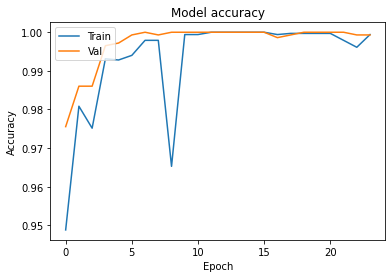

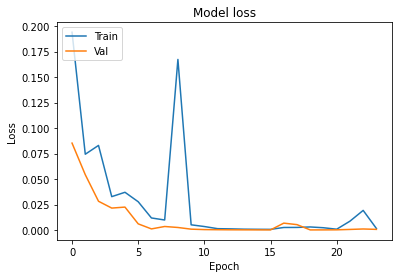

In [ ]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
model_lstm.evaluate(X_val, y_val, batch_size=batch_size, workers=4)

45/45 [==============================] - 5s 114ms/step - loss: 6.3708e-04 - accuracy: 0.9993


[0.000637079996522516, 0.9993016719818115]

### 6.2 Model Predict

In [ ]:
prediction = model_lstm.predict(X_test)

array([[9.99833941e-01, 1.66069032e-04],
       [9.99915361e-01, 8.45936011e-05],
       [9.99869227e-01, 1.30771296e-04],
       [9.99910355e-01, 8.96087295e-05],
       [9.99921918e-01, 7.81011331e-05],
       [9.99901056e-01, 9.89685359e-05],
       [9.99921560e-01, 7.84755975e-05],
       [9.99897242e-01, 1.02774080e-04],
       [9.99908686e-01, 9.13376134e-05],
       [9.99893188e-01, 1.06821441e-04],
       [9.99898314e-01, 1.01714664e-04],
       [9.99898911e-01, 1.01099664e-04],
       [9.99914646e-01, 8.53629463e-05],
       [9.99917507e-01, 8.24568924e-05],
       [9.99879003e-01, 1.20941862e-04],
       [9.99914169e-01, 8.58479252e-05],
       [1.22918500e-04, 9.99877095e-01],
       [7.37013703e-04, 9.99262989e-01],
       [9.99913335e-01, 8.66251139e-05],
       [9.99869704e-01, 1.30287983e-04]], dtype=float32)

In [ ]:
prd = tf.argmax(prediction,axis=-1)

In [ ]:
y_test = test['fishing'].values

In [ ]:
y_test.shape, prd.shape

((1193,), TensorShape([1193]))

In [ ]:
result = pd.DataFrame(prd,columns=['predict'])

In [ ]:
result['ground'] = y_test

In [ ]:
len(result[result['predict']==result['ground']]), len(result)

(1193, 1193)